In [3]:
# import pandas as pd

# # df_ = pd.read_excel("Total.xlsx", index_col=None)

# df = pd.ExcelFile("Total.xlsx")
# print(df.sheet_names)
# df1 = pd.read_excel(df, '1st')
# df2 = pd.read_excel(df, '2nd')
# df3 = pd.read_excel(df, '3rd')
# df_ = pd.concat([df1,df2,df3],axis=0)

# cluster = df_['Cluster'].str.split(' ', n=1, expand=True)
# cluster = cluster.rename(columns={0:'cluster', 1:'kPa'})
# features = df_.drop('Cluster', axis=1)

# df_ = pd.concat([features, cluster], axis=1)
# df_.reset_index(drop=True, inplace=True)
# df_.to_csv('Total.csv', index=False)
# print(df_)

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# np.random.seed(42)

df = pd.read_csv('Total.csv', index_col = None)
columns_new = dict([(name, name.replace('.','__')) for name in df.columns])
df.rename(columns=columns_new, inplace=True)


print(df['kPa'].unique())
kPa = '60kPa'
df_ = df[df['kPa']==kPa]
X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
# X = X.iloc[:,feature_selected]
y_ = df_.cluster # Dependent variable

y = np.zeros(y_.shape)
y[y_=='TIF'] = 1
y = pd.DataFrame(y, columns=['cluster'], dtype=float)
# y_.loc[y_=='CAF'] = 0
# y_.loc[y_=='TIF'] = 1
# y = y_.astype(float)


X_columns_new = dict([(name, f'ind_{i}_'+name) for i,name in enumerate(X.columns)])
X.rename(columns=X_columns_new, inplace=True)
features = np.array(X.columns)

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

['1kPa' '4kPa' '6kPa' '22kPa' '60kPa' '0.5kPa']


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

X_train.shape

(241, 149)

In [88]:
### initialize selected features
unique = np.arange(X_train.shape[1])  

# unique = np.array([[105,   1, 106,  37,   8,  87,  53]])

In [89]:
from model import get_importance_index

scoring = 'roc_auc'
ranked_idx, importance_score, F1 = get_importance_index(X_train.iloc[:,unique], y_train, X_test.iloc[:,unique], y_test, scoring)

  7%|▋         | 7/104 [00:05<01:10,  1.37it/s]


KeyboardInterrupt: 

In [128]:
# percent = importance_score/importance_score.sum(0)

# percent.sort(axis=0)
# # plt.plot(percent[::-1,2])
# # print(np.cumsum(percent, axis=0))
# plt.plot(np.cumsum(percent[::-1],axis=0))


In [129]:
epoch = 5
remove_group_num = np.array([50,32,15, 7,3,1,1,1,1,1,1])
remove_order_num = np.array([10, 8, 5, 3,2,1,1,1,1,1,1])  #60,40,20,10,5,2,2,2,2,2,2
assert X_train.shape[1]==149
remove = 149-np.cumsum(remove_group_num+remove_order_num)

ranked_idx = ranked_idx[:,F1>.8]
ranked_idx_ = unique[ranked_idx.flatten()]
# ranked_idx = ranked_idx[:int(ranked_idx.shape[0]*3/4)] ## remove low ranking features

In [130]:
unique_rank = []
for i in ranked_idx_.flatten():
    if i not in unique_rank:
        unique_rank.append(i)

unique_rank = np.array(unique_rank)[:-remove_order_num[epoch]]
unique_rank, unique_rank.shape
# unique = unique[current_idx]

(array([98,  1, 11, 38, 43,  2,  7, 50, 87, 30, 94]), (11,))

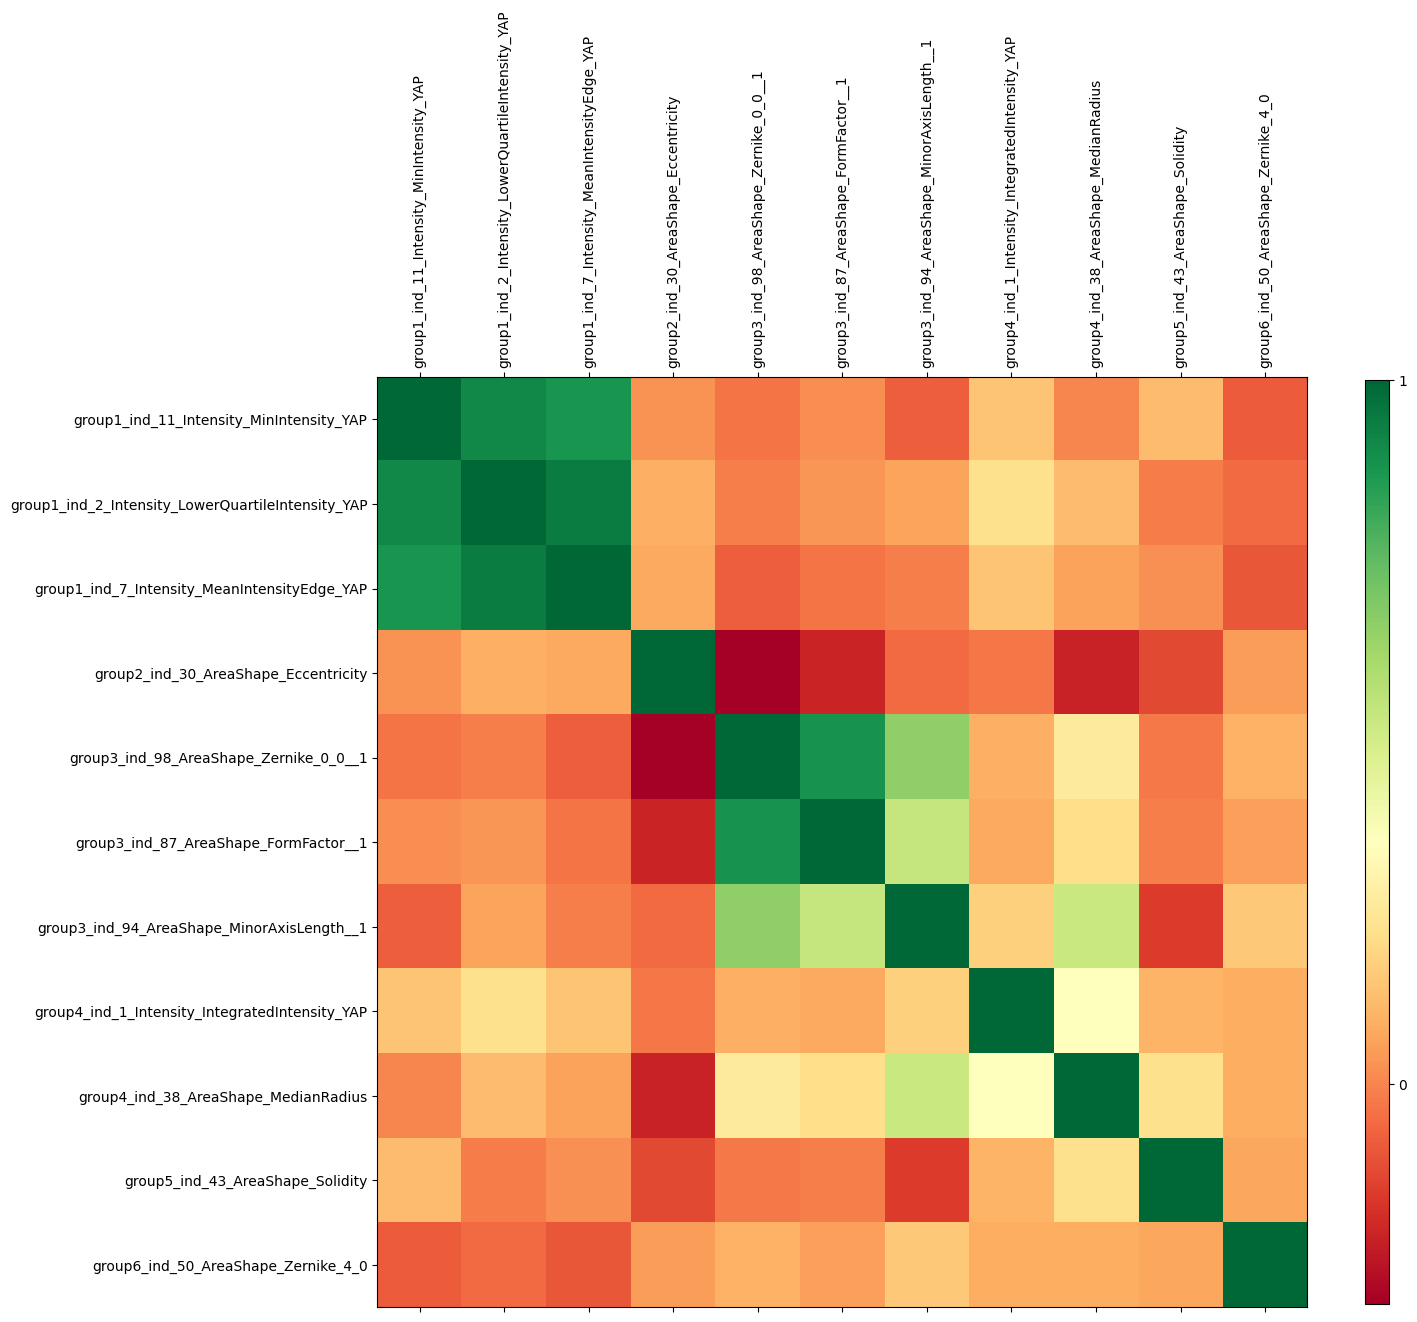

In [131]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

# plot_corr(selected)

import scipy
import scipy.cluster.hierarchy as sch

selected = X.iloc[:, unique_rank]

corr_values = selected.corr().values
d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
selected_sorted = selected.reindex(columns, axis=1)

selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
selected_sorted.rename(columns=selected_columns_new, inplace=True)

plot_corr(selected_sorted, size=15)

In [132]:
group_member = []
for i in np.unique(ind):
    group_member.append(unique_rank[ind==i])

for i in group_member:
    print(i)


[11  2  7]
[30]
[98 87 94]
[ 1 38]
[43]
[50]


In [133]:
### select percent(per) of current feature, spread in each group has num features
num = remove_group_num[epoch]//np.unique(ind).shape[0]+1
print(num)

unique_ = []
for member in group_member:
    unique_.extend(list(member[:-num]))

unique_ = np.array(unique_)[:remove[epoch]]
print(unique_.shape)


extra = []
for i in unique_rank:
    if i not in unique_:
        extra.append(i)
    if len(extra) == remove[epoch]-unique_.shape[0]:
        break
    
unique_ = np.r_[unique_, extra]
print(unique_.shape)

1
(5,)
(11,)


In [134]:
unique = unique_

In [ ]:
selected_sorted.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
selected_y = pd.concat([selected_sorted,y], axis=1)


## get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

status_name = 'cluster'
anova_list = list(selected_sorted.columns)
    
pvalue = {}
pvalue_problem = {}
for cov in anova_list:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{status_name} ~ {cov}', data=selected_y).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    _pvalue = anova_table['PR(>F)'][cov]
    pvalue[cov] = _pvalue

    if _pvalue>.05:
        print(f'{cov}: {_pvalue}')
        pvalue_problem[cov] = _pvalue
        
# print(pvalue_problem)

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# np.random.seed(42)



def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    # %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

# plot_corr(selected)

import scipy.cluster.hierarchy as sch
def feature_extraction(X_train, y_train, X_test, y_test, X):

    assert X_train.shape[1]==149
    remove_group_num = np.array([50,32,15, 7,3,1,1,1,1,1,1])
    remove_order_num = np.array([10, 8, 5, 3,2,1,1,1,1,1,1])  #60,40,20,10,5,2,2,2,2,2,2
    remove = 149-np.cumsum(remove_group_num+remove_order_num)


    from model import get_importance_index
    unique = np.arange(X_train.shape[1])  

    F1_list, idx_list = [], []
    for epoch in range(remove_order_num.shape[0]):

        ################ feature importance ranking #################
        scoring = 'roc_auc'
        ranked_idx, importance_score, F1 = get_importance_index(X_train.iloc[:,unique], y_train, X_test.iloc[:,unique], y_test, scoring)
        #############################################################


        ############### remove features by importance ranking ##################
        ranked_idx = ranked_idx[:,F1>.8]
        ranked_idx_ = unique[ranked_idx.flatten()]

        unique_rank = []
        for i in ranked_idx_.flatten():
            if i not in unique_rank:
                unique_rank.append(i)

        unique_rank = np.array(unique_rank)[:-remove_order_num[epoch]]
        # unique_rank, unique_rank.shape
        ########################################################################
        F1_list.append(F1)
        idx_list.append(unique_rank)

        ############### group selected feature by correlation values ################
        selected = X.iloc[:, unique_rank]

        corr_values = selected.corr().values
        d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
        selected_sorted = selected.reindex(columns, axis=1)

        selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
        selected_sorted.rename(columns=selected_columns_new, inplace=True)
        # plot_corr(selected_sorted, size=15)
        ############################################################################


        ########################### remove features by groups(avoid selected features highly correlated) ###############
        group_member = []
        for i in np.unique(ind):
            group_member.append(unique_rank[ind==i])
        # for i in group_member:
        #     print(i)

        ### select percent(per) of current feature, spread in each group has num features
        num = remove_group_num[epoch]//np.unique(ind).shape[0]+1
        # print(num)

        unique_ = []
        for member in group_member:
            unique_.extend(list(member[:-num]))
        unique_ = np.array(unique_)[:remove[epoch]]
        # print(unique_.shape)

        extra = []
        for i in unique_rank:
            if i not in unique_:
                extra.append(i)
            if len(extra) == remove[epoch]-unique_.shape[0]:
                break
            
        unique_ = np.r_[unique_, extra]
        # print(unique_.shape)
        ################################################################################################################

        unique = unique_

    return F1_list, idx_list


def get_data(df_):
    # kPa = '22kPa'
    # df_ = df[df['kPa']==kPa]
    X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
    # X = X.iloc[:,feature_selected]
    y_ = df_.cluster # Dependent variable

    y = np.zeros(y_.shape)
    y[y_=='TIF'] = 1
    y = pd.DataFrame(y, columns=['cluster'], dtype=float)
    # y_.loc[y_=='CAF'] = 0
    # y_.loc[y_=='TIF'] = 1
    # y = y_.astype(float)


    X_columns_new = dict([(name, f'ind_{i}_'+name) for i,name in enumerate(X.columns)])
    X.rename(columns=X_columns_new, inplace=True)
    features = np.array(X.columns)

    # Split into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train.iloc[:,:] = scaler.transform(X_train)
    X_test.iloc[:,:] = scaler.transform(X_test)

    X_train.shape

    return X_train, y_train, X_test, y_test, X, features


df = pd.read_csv('Total.csv', index_col = None)
columns_new = dict([(name, name.replace('.','__')) for name in df.columns])
df.rename(columns=columns_new, inplace=True)

kPa_list = df['kPa'].unique()
kPa_list

array(['1kPa', '4kPa', '6kPa', '22kPa', '60kPa', '0.5kPa'], dtype=object)

In [2]:
import pickle

F1_kPa, idx_kPa = [], []
for kPa in kPa_list:
# for kPa in ['22kPa']:
    df_ = df[df['kPa']==kPa]
    X_train, y_train, X_test, y_test, X, features = get_data(df_)
    F1_list, idx_list = feature_extraction(X_train, y_train, X_test, y_test, X)
    
    F1_kPa.append(F1_list)
    idx_kPa.append(idx_list)

    with open(f'F1_{kPa}', 'wb') as file:
        pickle.dump(F1_list, file)

    with open(f'idx_{kPa}', 'wb') as file:
        pickle.dump(idx_list, file)

{'C': 0.5, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.66676418 0.84608641 0.82051282]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.63151098 0.86318792 0.87179487]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.57277446 0.84608641 0.86318792]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.57189984 0.84608641 0.85476456]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.54714107 0.84608641 0.83744071]
{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.53846154 0.86328783 0.84608641]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.54621062 0.85476456 0.8289849 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.52157745 0.8203292  0.8289849 ]
{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.52991453 0.84608641 0.8461988 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.54654513 0.85470085 0.8461988 ]
{'C': 0.5, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.36697014 0.87166372 0.83760684]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.78447852 0.84988648 0.82230513]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77534578 0.86895171 0.84070152]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.79406697 0.87818351 0.83150934]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.74699652 0.85944251 0.85906906]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.73650825 0.88707497 0.89630097]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.73650825 0.92494324 0.89692451]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.73650825 0.92494324 0.89665064]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76432038 0.92471664 0.91544143]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.68004573 0.89630097 0.90617905]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.71386091 0.85971458 0.84120502]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.71535524 0.87818351 0.86915888]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.92917025 0.92027904 0.8848475 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.001}


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.92917025 0.92917025 0.8848475 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.92917025 0.92027904 0.87604794]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.83170019 0.82273109]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.84063306 0.84063306]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.80527924 0.83146225 0.82292562]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83183206 0.82273109 0.83183206]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.84889441 0.84941596]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.81407194 0.82273109 0.81398442]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.80527924 0.86667154 0.84045798]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.78757735 0.85818487 0.82273109]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 2, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86354811 0.8720207  0.87103135]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86352859 0.85480778 0.86220691]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86352859 0.86342875 0.86220691]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.80382137 0.88058751 0.83710135]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82943514 0.88058751 0.86263845]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.81235181 0.87207658 0.86298488]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.82941073 0.8806046  0.85480778]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82090721 0.8720207  0.8206449 ]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.81221453 0.79514313 0.8028069 ]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.78670117 0.83772634 0.81944389]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.75231915 0.81221453 0.81160421]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.79925842 0.88421948 0.85498289]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.7897207  0.88372917 0.86366479]
{'C': 1.0, 'fit_intercept': False, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.79911533 0.90351623 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.79910609 0.93201112 0.91258573]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.78014017 0.95166096 0.89316033]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77965624 0.94210974 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77965624 0.90310765 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76085158 0.90310765 0.89316033]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76085158 0.90351623 0.88372917]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.75139978 0.88461538 0.87431851]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.72278543 0.85498289 0.87431851]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82159845 0.85319746 0.86110483]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82159845 0.84476422 0.89378604]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83739837 0.83688607 0.86950885]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83739837 0.82901182 0.87744543]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82989102 0.85319746 0.84529641]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.84529641 0.83781677 0.86950885]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.85454224 0.85403509 0.87695187]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83852876 0.83781677 0.86110483]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


Liblinear failed to converge, increase the number of iterations.
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.84573821 0.85319746 0.88582025]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 1.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.86197629 0.87025342 0.86197629]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.87786558 0.87025342 0.86197629]


In [22]:
# import pickle

# # with open('F1_kPa', 'wb') as file:
# #     pickle.dump(F1_kPa, file)

# # with open('idx_kPa', 'wb') as file:
# #     pickle.dump(idx_kPa, file)



# with open('F1_kPa', 'rb') as file:
#     F1_kPa = pickle.load(file)

# with open('idx_kPa', 'rb') as file:
#     idx_kPa = pickle.load(file)

In [10]:
kPa_list = df['kPa'].unique()

kPa_list

array(['1kPa', '4kPa', '6kPa', '22kPa', '60kPa', '0.5kPa'], dtype=object)

In [16]:
import pickle

with open('F1_1kPa', 'rb') as file:
    F1_1kPa = pickle.load(file)      ### F1 score of each iteration by different methods
with open('idx_1kPa', 'rb') as file:
    idx_1kPa = pickle.load(file)     ### selected features in each iteration

with open('F1_4kPa', 'rb') as file:
    F1_4kPa = pickle.load(file)
with open('idx_4kPa', 'rb') as file:
    idx_4kPa = pickle.load(file)

with open('F1_6kPa', 'rb') as file:
    F1_6kPa = pickle.load(file)
with open('idx_6kPa', 'rb') as file:
    idx_6kPa = pickle.load(file)

with open('F1_22kPa', 'rb') as file:
    F1_22kPa = pickle.load(file)
with open('idx_22kPa', 'rb') as file:
    idx_22kPa = pickle.load(file)

with open('F1_60kPa', 'rb') as file:
    F1_60kPa = pickle.load(file)
with open('idx_60kPa', 'rb') as file:
    idx_60kPa = pickle.load(file)

with open('F1_0.5kPa', 'rb') as file:
    F1_5kPa = pickle.load(file)
with open('idx_0.5kPa', 'rb') as file:
    idx_5kPa = pickle.load(file)


F1_kPa = [F1_1kPa, F1_4kPa, F1_6kPa, F1_22kPa, F1_60kPa, F1_5kPa]
idx_kPa = [idx_1kPa, idx_4kPa, idx_6kPa, idx_22kPa, idx_60kPa, idx_5kPa]

In [17]:
idx_26 = np.array(np.r_[[idx_[3] for idx_ in idx_kPa]], dtype=int)
idx_17 = np.array(np.r_[[idx_[4] for idx_ in idx_kPa]], dtype=int)
idx_13 = np.array(np.r_[[idx_[5] for idx_ in idx_kPa]], dtype=int)
idx_11 = np.array(np.r_[[idx_[6] for idx_ in idx_kPa]], dtype=int)
idx_9 = np.array(np.r_[[idx_[7] for idx_ in idx_kPa]], dtype=int)
idx_7 = np.array(np.r_[[idx_[8] for idx_ in idx_kPa]], dtype=int)
idx_5 = np.array(np.r_[[idx_[9] for idx_ in idx_kPa]], dtype=int)
# idx_3 = np.array(np.r_[[idx_[10] for idx_ in idx_kPa]], dtype=int)

print(np.sort(idx_13,axis=1))
print(np.sort(idx_11,axis=1))


[[  1   2   4   7   9  10  11  13  22  36  43  82  91]
 [  1   2   7   9  10  20  33  51  68  94 106 118 134]
 [  3  13  15  52  56  84 105 106 113 122 131 141 148]
 [  1   2   7  10  11  20  34  38  39  40  50  84  94]
 [  1   2   3  10  14  37  84  87  98 105 106 131 148]
 [  1   2   7   8   9  10  11  13  46  64  83  95 140]]
[[  1   2   4   7   9  10  11  13  36  43  82]
 [  1   2   7   9  10  20  33  68 106 118 134]
 [  3  13  52  56  84 105 106 113 131 141 148]
 [  1   2   7  10  11  34  38  39  40  50  84]
 [  1   2  14  37  84  87  98 105 106 131 148]
 [  1   2   7   8   9  10  11  46  83  95 140]]


In [18]:
print(np.sort(idx_9,axis=1))
print(np.sort(idx_7,axis=1))
print(np.sort(idx_5,axis=1))

[[  1   2   4   7  10  11  13  36  43]
 [  1   2   7   9  10  20  33 106 134]
 [  3  13  52  56 105 106 113 141 148]
 [  1   2   7  10  11  38  40  50  84]
 [  1   2  14  37  84  87 105 131 148]
 [  2   7   9  10  11  46  83  95 140]]
[[  1   2   4  10  11  13  36]
 [  1   2   7   9  10  20 106]
 [  3  13 105 106 113 141 148]
 [  1   2  10  11  38  40  84]
 [  1   2  14  37  84  87 105]
 [  2   7   9  10  11  83 140]]
[[  1   2  10  11  13]
 [  1   2   7   9 106]
 [  3 106 113 141 148]
 [  1  11  38  40  84]
 [  1  14  37  84 105]
 [  2   7   9  10  11]]


In [19]:
df_ = df[df['kPa']==kPa_list[0]]
X_train, y_train, X_test, y_test, X, features = get_data(df_)

In [20]:
unique, count = np.unique(idx_17, return_counts=True)
unique[count>4], features[unique[count>3]]

(array([ 1,  2,  7, 10, 11]),
 array(['ind_1_Intensity_IntegratedIntensity_YAP',
        'ind_2_Intensity_LowerQuartileIntensity_YAP',
        'ind_7_Intensity_MeanIntensityEdge_YAP',
        'ind_10_Intensity_MinIntensityEdge_YAP',
        'ind_11_Intensity_MinIntensity_YAP',
        'ind_106_AreaShape_Zernike_4_4__1'], dtype=object))

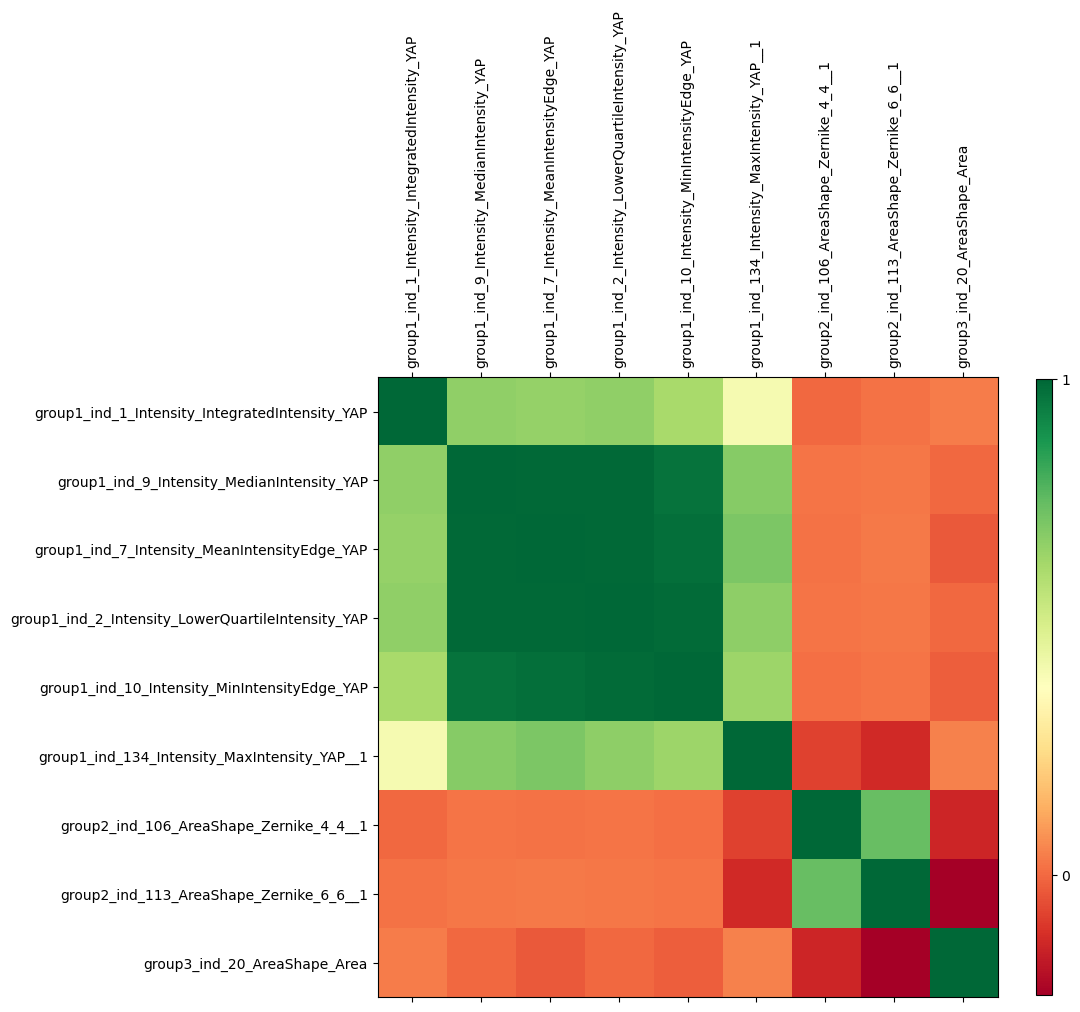

In [106]:
ii = 1
kPa_list = df['kPa'].unique()

df_ = df[df['kPa']==kPa_list[ii]]
X_train, y_train, X_test, y_test, X, features = get_data(df_)

# selected = X.iloc[:, idx_13[ii]]
# selected = X.iloc[:, idx_11[ii]]
selected = X.iloc[:, idx_9[ii]]
# selected = X.iloc[:, idx_7[ii]]
# selected = X.iloc[:, idx_5[ii]]

corr_values = selected.corr().values
d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
selected_sorted = selected.reindex(columns, axis=1)

selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
selected_sorted.rename(columns=selected_columns_new, inplace=True)

plot_corr(selected_sorted)